# Trading strategy on SP500 stocks by use of K-means clustering algorithm

In less than 2 weeks time I created this trading strategy and ran a backtest on it. The main goal of this assignment was to improve my Python data science skills and get a better understanding of algorithmic trading. This notebook is build up in five parts. In the first part I explore the dataframe that I created with data from Yahoo finance. In the second part I create relevant features. In the third part I cluster stocks on bèta and average return over a 5 year period (2013-2017). In the fourth part I create a trading strategy based on growth or decline in the market rolling moving average. In the fifth part I backtest my strategy over a two year period (2018-2019). 

In [273]:
import numpy as np
import pandas as pd 
from pylab import plot,show
import pandas_datareader as dr
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
import bs4 as bs
import requests
import yfinance as yf
import datetime # importing all nescessary libraries


### Getting SP500 price data

In [274]:
Alldf = pd.read_csv("sp500_Prices2013till2019.csv") #importing the dataframe that I created in another notebook. 

### Data exploration

In this part I will chunk my dataframe into two. One runs from 2013 till the end of 2017 and one from 2018 till the end of 2019. I do this because I do not want to backtest my strategy over the same period on which I clustered my stocks. Otherwise the results might be biased. I also decided to not include 2020, because this would not be an optimal year to test a trading strategy due to the Covid 19 outbreak. I also discovered that there are some missing values in the dataset because some stocks were not traded for the entire time period. I decided to leave them unchanged for now, as it would otherwise mess up the results when computing the stock returns. 

In [275]:
Alldf.head() # My dataframe is not indexed. Besides my date column all columns are stock symbols, all values are the adjusted close prices on a certain day. 

,Date,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,...,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBRA,ZBH,ZION,ZTS
0,2013-01-02,76.235191,27.382978,25.027666,13.69,58.386585,10.243313,38.340000,2.53,70.995186,...,96.279900,20.939499,14.776089,31.153555,24.603680,41.311356,40.959999,63.264393,19.460474,NaN
1,2013-01-03,76.146736,28.425323,24.821001,13.45,58.175224,10.299441,37.750000,2.49,70.995186,...,97.315514,20.878317,14.776089,31.094772,24.523157,41.569702,41.000000,64.170830,19.487015,NaN
2,2013-01-04,76.709747,28.254448,24.507444,13.41,58.496490,10.449116,38.130001,2.59,72.101913,...,98.489761,20.954798,14.611683,30.657999,24.487370,42.024899,40.669998,64.497902,20.044556,NaN
3,2013-01-07,76.806290,28.485126,24.557327,13.25,58.242851,10.458469,37.939999,2.67,71.857071,...,98.824097,20.733017,14.858288,30.531998,24.165289,41.760395,40.900002,64.656769,19.947205,NaN
4,2013-01-08,76.814316,28.493668,24.022856,13.21,58.581032,10.280732,38.139999,2.67,70.681801,...,98.742554,20.771250,14.837740,29.910440,23.870043,40.007313,40.930000,64.750221,19.548969,NaN


In [276]:
Alldf.tail() # my dataframe runs till the end of 2019, I need to chunk this in two dataframes one from 2013-2017 and one from 2018-2019. 

,Date,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,...,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBRA,ZBH,ZION,ZTS
1757,2019-12-24,170.337433,85.925331,85.136879,172.300003,208.266663,58.425743,329.640015,46.540001,159.305710,...,138.279648,61.655396,35.554531,97.003059,77.613426,98.435898,254.330002,149.679855,49.653328,132.162842
1758,2019-12-26,170.250656,85.925331,85.117928,171.009995,208.699707,58.505219,331.200012,46.630001,158.015945,...,139.767166,61.586739,35.659187,97.190186,77.573936,99.868332,254.419998,149.351959,49.778591,132.272202
1759,2019-12-27,170.896606,86.043480,84.520973,169.270004,208.867004,58.803261,330.790009,46.180000,157.103195,...,138.646561,61.910412,35.497444,96.934113,77.810806,99.976257,256.000000,149.063782,49.624416,132.490967
1760,2019-12-30,169.517944,85.452782,83.876648,167.289993,207.311966,58.495289,328.339996,45.520000,157.867111,...,138.220154,62.077152,35.344193,96.205284,77.712112,98.740044,254.110001,147.811737,49.884586,131.456894
1761,2019-12-31,170.086777,85.511848,83.895599,170.589996,207.243088,59.031757,329.809998,45.860001,158.898956,...,137.714386,62.273323,35.315456,96.293915,77.761459,98.828346,255.440002,148.735870,50.029121,131.596085


In [277]:
Alldf.dtypes # the Date column data type is incorrect as it should be a datetime. 

Date     object
MMM     float64
ABT     float64
ABBV    float64
ABMD    float64
         ...   
YUM     float64
ZBRA    float64
ZBH     float64
ZION    float64
ZTS     float64
Length: 504, dtype: object

In [278]:
Alldf['date'] =  pd.to_datetime(Alldf['Date'], infer_datetime_format=True)
del Alldf['Date']
Alldf.set_index(['date'], inplace=True) # setting date to a datetime and making it the index of my dataframe. 

In [279]:
df = Alldf[~(Alldf.index > '2017-12-31')]
df.reset_index(level=0, inplace=True)
df = df.melt('date', var_name='Name', value_name='Prices')
dfTest = Alldf[~(Alldf.index < '2017-12-31')] #splitting my new dataframe up in two, one to cluster my stocks with and one to backtest my strategy. 

In [280]:
df.tail() # my df for clustering now runs till the end of 2017, and the other one from 2018 till the end of 2019. 

,date,Name,Prices
633272,2017-12-22,ZTS,70.705208
633273,2017-12-26,ZTS,71.048958
633274,2017-12-27,ZTS,71.156982
633275,2017-12-28,ZTS,71.098068
633276,2017-12-29,ZTS,70.754311


In [281]:
df['Name'].value_counts() #in total the five year df has 1259 business days and 503 stocks to work with. 

SWK    1259
CPB    1259
LYV    1259
MO     1259
MRK    1259
       ... 
HCA    1259
KHC    1259
VTR    1259
UNM    1259
DE     1259
Name: Name, Length: 503, dtype: int64

In [282]:
df.isnull().sum() #I got 23432 missing data points in my dataframe. These exist because not all stocks were trading for the entire five year period.  

date          0
Name          0
Prices    23432
dtype: int64

### Feature engineering

In this part I will create many features that will help me to compute the average stock return and stock bèta, these are the two features that I will use to cluster all stocks. To compute the bèta I had to create many different features/variables. I applied the pivot in combination with the lambda function very often to rotate my dataframe and compute the feature that I needed. 

In [283]:
returns = df.pivot(index='date', columns='Name', values='Prices')
returns = returns.apply(lambda x:x).pct_change()*100
returns = returns.fillna(0) # computing the daily returns per stock and after that setting all missing values to 0. 

In [284]:
returns.head() # This dataframe now stores al the returns per stock on a certain day. The first day is 0.0, because there is no stock price known before the start date. 

Name,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2013-01-03,0.358156,-2.288973,0.000000,-1.262186,-0.825746,-0.206965,-1.753103,3.806544,-0.362003,-1.538863,...,-0.188687,-0.180348,-0.271477,0.000000,-0.327278,0.625365,1.432776,0.097658,0.136383,0.0
2013-01-04,1.974794,7.833084,1.558877,-2.785482,-1.263272,0.668206,-0.297397,-0.601138,0.552239,1.006625,...,-1.404652,0.462991,0.866110,-1.112648,-0.145934,1.095020,0.509690,-0.804883,2.861089,0.0
2013-01-07,-0.723268,0.746762,-0.339578,-0.588200,0.203542,0.320454,-1.193138,0.816433,-0.433597,-0.498302,...,-0.410990,-1.157807,0.343499,1.687724,-1.315293,-0.629397,0.246313,0.565536,-0.485673,0.0
2013-01-08,-0.799092,2.156344,-1.635566,0.269135,-2.176424,-0.136910,-0.301887,0.029984,0.580639,0.527150,...,-2.035757,0.625538,-1.149158,-0.138292,-1.221778,-4.197954,0.144536,0.073347,-1.996447,0.0


In [285]:
AvgStockReturn = returns.apply(lambda x: x).mean() # Computing the Average Stock Return over 5 year per stock based on the returns dataframe.

In [286]:
returns.reset_index(level=0, inplace=True)
returns = returns.melt('date', var_name='Name', value_name='returns') 
returns.head() #unpivoting the returns dataframe so it could be merged with the original df. 

,date,Name,returns
0,2013-01-02,A,0.000000
1,2013-01-03,A,0.358156
2,2013-01-04,A,1.974794
3,2013-01-07,A,-0.723268
4,2013-01-08,A,-0.799092


In [287]:
returns.set_index(['date','Name'], inplace=True)
df.set_index(['date', 'Name'], inplace=True)
df['returns'] = returns['returns']
df['returns'].describe() #merging the returns of the returns dataframe into the original df. It seemed to have worked. 

count    633277.000000
mean          0.072272
std           1.532459
min         -51.204455
25%          -0.613999
50%           0.026114
75%           0.779534
max          61.906564
Name: returns, dtype: float64

In [288]:
df.reset_index(level=0, inplace=True)
df['AvgStockReturn'] = AvgStockReturn
df['AvgStockReturn'].describe() #mergig the average stock return into the original df. It seemed to have worked. 

count    633277.000000
mean          0.072272
std           0.040728
min          -0.109501
25%           0.048624
50%           0.069421
75%           0.092234
max           0.256065
Name: AvgStockReturn, dtype: float64

In [289]:
df.head() #the df with the two new variables. returns= daily return per stock, AvgStockReturn = average return per stock over 5 year period. 

,date,Prices,returns,AvgStockReturn
Name,,,,
MMM,2013-01-02,76.235191,0.000000,0.086455
MMM,2013-01-03,76.146736,-0.116029,0.086455
MMM,2013-01-04,76.709747,0.739377,0.086455
MMM,2013-01-07,76.806290,0.125854,0.086455
MMM,2013-01-08,76.814316,0.010450,0.086455


In [290]:
df.reset_index(level=0, inplace=True)
dfPivot = df.pivot(index='Name', columns='date', values='returns')
AvgDaily = dfPivot.apply(lambda x: x).mean() #computing the average daily return for all stocks combined, also called market return.

In [291]:
df.set_index(['date'], inplace=True)
df['AvgDaily'] = AvgDaily
df['AvgMarketReturn'] = df['AvgDaily'].mean()
df.head() #merging the average daily return into the df and computing the average market return over the entire five year period. 

,Name,Prices,returns,AvgStockReturn,AvgDaily,AvgMarketReturn
date,,,,,,
2013-01-02,MMM,76.235191,0.000000,0.086455,0.000000,0.072272
2013-01-03,MMM,76.146736,-0.116029,0.086455,-0.014979,0.072272
2013-01-04,MMM,76.709747,0.739377,0.086455,0.681688,0.072272
2013-01-07,MMM,76.806290,0.125854,0.086455,-0.262149,0.072272
2013-01-08,MMM,76.814316,0.010450,0.086455,-0.296242,0.072272


In [292]:
df['DevFromAvgMarket'] = (df['AvgDaily']-df['AvgMarketReturn'])
df['DevFromAvgStock'] = (df['returns']-df['AvgStockReturn'])
df['SqrdDevFromMarket'] = df['DevFromAvgMarket']**2
df['ProductofDevs'] = df['DevFromAvgMarket']*df['DevFromAvgStock']
df['VarMarket'] = df['SqrdDevFromMarket'].mean()
df.head() #Based on the features that I created before, I computed several new columns, all function to eventually compute the bèta of stocks. 

,Name,Prices,returns,AvgStockReturn,AvgDaily,AvgMarketReturn,DevFromAvgMarket,DevFromAvgStock,SqrdDevFromMarket,ProductofDevs,VarMarket
date,,,,,,,,,,,
2013-01-02,MMM,76.235191,0.000000,0.086455,0.000000,0.072272,-0.072272,-0.086455,0.005223,0.006248,0.573212
2013-01-03,MMM,76.146736,-0.116029,0.086455,-0.014979,0.072272,-0.087251,-0.202485,0.007613,0.017667,0.573212
2013-01-04,MMM,76.709747,0.739377,0.086455,0.681688,0.072272,0.609416,0.652921,0.371387,0.397900,0.573212
2013-01-07,MMM,76.806290,0.125854,0.086455,-0.262149,0.072272,-0.334421,0.039399,0.111838,-0.013176,0.573212
2013-01-08,MMM,76.814316,0.010450,0.086455,-0.296242,0.072272,-0.368514,-0.076006,0.135803,0.028009,0.573212


In [293]:
df.reset_index(level=0, inplace=True)
dfPivot = df.pivot(index= 'date', columns='Name', values='ProductofDevs')
CovStock = dfPivot.apply(lambda x:x).mean() #Compute the covariance per stock which is also nescessary for computing the bèta of a stock. 

In [294]:
df.set_index(['Name'], inplace=True)
df['CovStock'] = CovStock
df['beta'] = df['CovStock']/df['VarMarket']
df['beta'].describe() # merging the covariance per stock into the original dataframe and compute bèta per stock afterwards. Bèta mean is 1, this is correct.

count    633277.000000
mean          1.000000
std           0.328176
min          -0.068740
25%           0.806674
50%           1.000888
75%           1.220637
max           2.126792
Name: beta, dtype: float64

In [295]:
df.reset_index(level=0, inplace=True)
df.set_index(['date', 'Name'], inplace=True)
df.sort_index(inplace=True)
df.head() #my dataframe ready for clustering, now all feature engineering is done. df is multi-indexed by date and stock name. 

Prices  returns  AvgStockReturn  AvgDaily  \
date       Name                                                 
2013-01-02 A     27.810661      0.0        0.077058       0.0   
           AAL   13.179525      0.0        0.132312       0.0   
           AAP   70.995186      0.0        0.043779       0.0   
           AAPL  16.926661      0.0        0.080407       0.0   
           ABBV  25.027666      0.0        0.107614       0.0   

                 AvgMarketReturn  DevFromAvgMarket  DevFromAvgStock  \
date       Name                                                       
2013-01-02 A            0.072272         -0.072272        -0.077058   
           AAL          0.072272         -0.072272        -0.132312   
           AAP          0.072272         -0.072272        -0.043779   
           AAPL         0.072272         -0.072272        -0.080407   
           ABBV         0.072272         -0.072272        -0.107614   

                 SqrdDevFromMarket  ProductofDevs  VarMarket  CovStock  \
date       Name                                                          
2013-01-02 A              0.005223       0.005569   0.573212  0.716968   
           AAL            0.005223       0.009563   0.573212  0.826133   
           AAP            0.005223       0.003164   0.573212  0.543951   
           AAPL           0.005223       0.005811   0.573212  0.484024   
           ABBV           0.005223       0.007778   0.573212  0.595851   

                     beta  
date       Name            
2013-01-02 A     1.250790  
           AAL   1.441235  
           AAP   0.948953  
           AAPL  0.844408  
           ABBV  1.039496

### Clustering of stocks 

In this part, I will first create an elbow plot that provides an indication for an optimal amount of clusters. After that, I will cluster the stocks in 6 different clusters based on their bèta's and average returns. I will create these clusters by applying a K-means algorithm. Next to my clustering algorithm I also create a regression model to show the expected average return based on bèta. This will indicate which stock did perform well in comparison to their risk and which ones did not. 

In [207]:
df.reset_index(level=0, inplace=True)
X = df[['beta', 'AvgStockReturn']]
X = X.drop_duplicates( keep='first')
X #store all relevant features in one variable X

,beta,AvgStockReturn
Name,,
A,1.250790,0.077058
AAL,1.441235,0.132312
AAP,0.948953,0.043779
AAPL,0.844408,0.080407
ABBV,1.039496,0.107614
...,...,...
YUM,0.992129,0.060288
ZBH,0.926157,0.058014
ZBRA,1.350400,0.097149


Text(0.5, 1.0, 'Elbow curve')

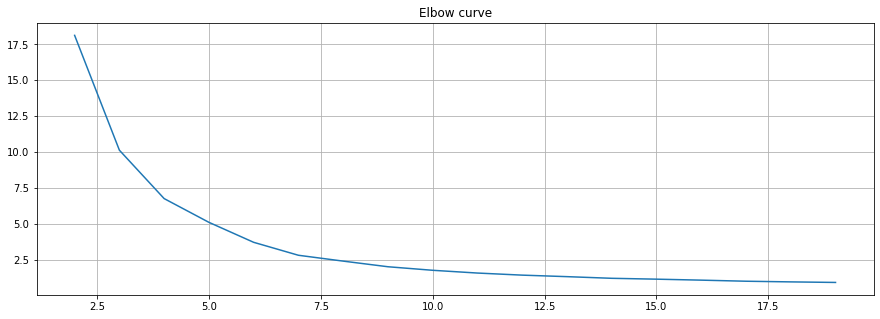

In [208]:
distorsions = []
for k in range(2, 20):
    k_means = KMeans(n_clusters=k)
    k_means.fit(X)
    distorsions.append(k_means.inertia_)
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve') #create an elbow curve to determine an appropriate number of clusters. It shows that an optimal number is somewhere between 4 and 7. I choose 6.


In [209]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X) #scaling the features so all variables have the same spread. Otherwise K-means might put too much emphasis on one feature.

In [210]:
kmeans = KMeans(
    init="random",
    n_clusters=6,
    n_init=10,
    max_iter=300,
    random_state=42)
kmeans = kmeans.fit(scaled_features)
centroids = kmeans.cluster_centers_ # set the K-means algorithm to create 6 clusters and let it run as often as needed to reach an optimum. 

In [211]:
x= scaled_features[:,0]
y= scaled_features[:,1]
linear = linear_model.LinearRegression()
x.shape= (495,1)
y.shape= (495,1)
res = linear.fit(x,y)
a = res.coef_[0][0]
i = res.intercept_[0]
model = a*x+i # Create a regresion model in order to determine which stocks have performed reasonably well in comparison to their riskiness. 

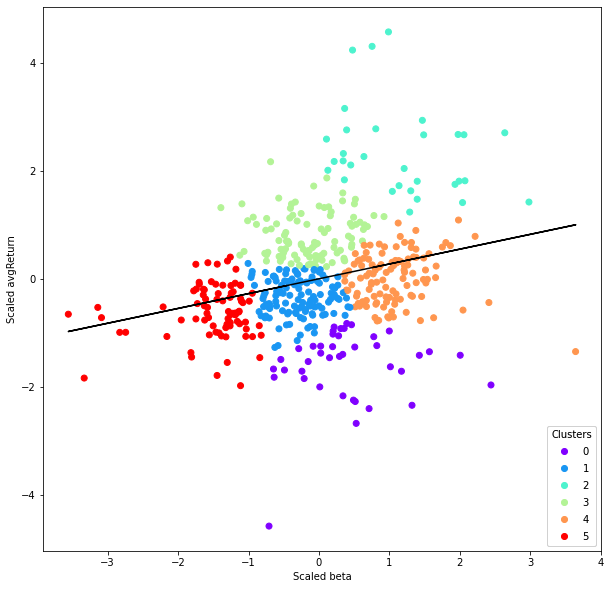

In [212]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
scatter = ax.scatter(scaled_features[:,0],scaled_features[:,1], c = kmeans.labels_, cmap ="rainbow")
regression = ax.plot(x, model, color= "black")
xlablel = ax.set_xlabel('Scaled beta')
ylabel = ax.set_ylabel('Scaled avgReturn')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Clusters")
ax.add_artist(legend1)
plt.show() #create a graph visualizing both the K-means clustering and the regression model. 

The graph shows that stocks in cluster 2 and 3 are the best performers. These are the only clusters in which each stock had a positive alpha (dots above regression plot). Stocks in cluster 0 performed the worst as each stock in this cluster had a negative alpha. Stocks in cluster 5, 1 and 4 had somewhat average performances for their corresponding bèta's. In addition, cluster 5 is also clearly the cluster with the lowest bèta. Therefore, stocks in this cluster are likely to produce the most stable returns. 

In [213]:
company = pd.DataFrame(X.index)
cluster_labels = pd.DataFrame(kmeans.labels_)
cluster = pd.concat([company, cluster_labels],axis = 1)
cluster.set_index(['Name'], inplace=True)
cluster['cluster'] = cluster.loc[:,0]
del cluster[0]
cluster.head() #creating a dataframe that indicates which stock belongs to which cluster

,cluster
Name,
A,4
AAL,2
AAP,1
AAPL,1
ABBV,3


### Creating a trading strategy 

In [214]:
df['cluster'] = cluster['cluster'] #merging the clusters of each stock in the original dataframe

In [215]:
df.reset_index(level=0, inplace=True)
a = df.groupby(['date','cluster']).mean()
df_Cluster = a['Prices']
df_Cluster = pd.DataFrame(df_Cluster) # computing the average stock price per day of each cluster and store it in a new cluster dataframe 

In [216]:
df_Cluster.reset_index(level=0, inplace=True)
df_Cluster.reset_index(level=0, inplace=True)
df_Cluster = df_Cluster.pivot(index='date', columns='cluster', values='Prices')
df_Cluster.head() #pivoting the new dataframe into a readable format

cluster,0.0,1.0,2.0,3.0,4.0,5.0
date,,,,,,
2013-01-02,49.960970,44.969102,21.581872,57.603788,47.183903,51.319083
2013-01-03,50.122879,44.942143,21.696945,57.736442,47.165437,51.271079
2013-01-04,50.621325,45.196428,21.877974,58.109983,47.563628,51.471453
2013-01-07,50.480049,45.143655,21.753207,58.283592,47.533771,51.195687
2013-01-08,50.447415,45.011535,21.670585,58.144701,47.360238,50.972293


In [217]:
df_Cluster['market'] = df_Cluster.mean(axis=1)
df_Cluster['MarketMA'] = df_Cluster['market'].rolling(window=20, min_periods=1).mean()
df_Cluster.head() #computing the average price of all clusters (market price) and the monthly (20 business days) moving average of the market. 

cluster,0.0,1.0,2.0,3.0,4.0,5.0,market,MarketMA
date,,,,,,,,
2013-01-02,49.960970,44.969102,21.581872,57.603788,47.183903,51.319083,45.436453,45.436453
2013-01-03,50.122879,44.942143,21.696945,57.736442,47.165437,51.271079,45.489154,45.462804
2013-01-04,50.621325,45.196428,21.877974,58.109983,47.563628,51.471453,45.806799,45.577469
2013-01-07,50.480049,45.143655,21.753207,58.283592,47.533771,51.195687,45.731660,45.616016
2013-01-08,50.447415,45.011535,21.670585,58.144701,47.360238,50.972293,45.601128,45.613039


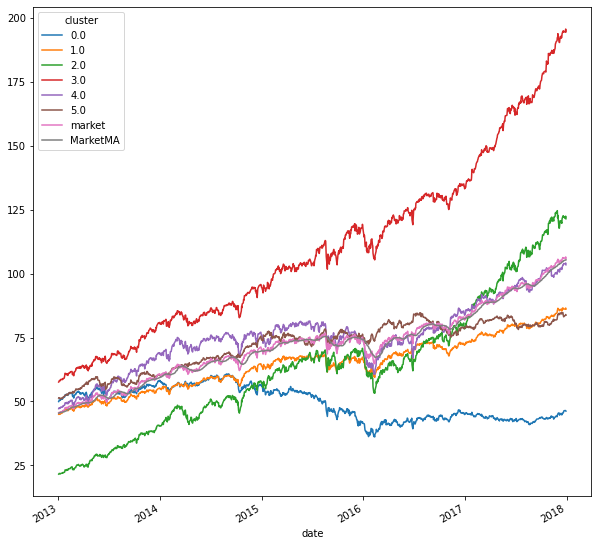

In [218]:
df_Cluster.plot(figsize=(10,10)) #plotting the development of prices of each cluster and market over time. 

As expected, the graph shows that stocks in cluster 2 and 3 had the highest returns over the entire period, but have also been relatively unstable (high bèta's). Cluster 0 had clearly been the worst performer. The plot also shows that cluster 5, 4 and 1 had somewhat average returns. However, it appears that cluster 4 and 1 were kind of mimicking the market, whereas cluster 5 remained relatively stable even when the market had big drawdowns. This is why I choose to continue to focus on cluster 2 and 3, because of their above average returns, and on cluster 5, because of its stability (low bèta). 

In [219]:
del df_Cluster[0]
del df_Cluster[4]
del df_Cluster[1] #removing the clusters that seem irrelevant for my strategy.

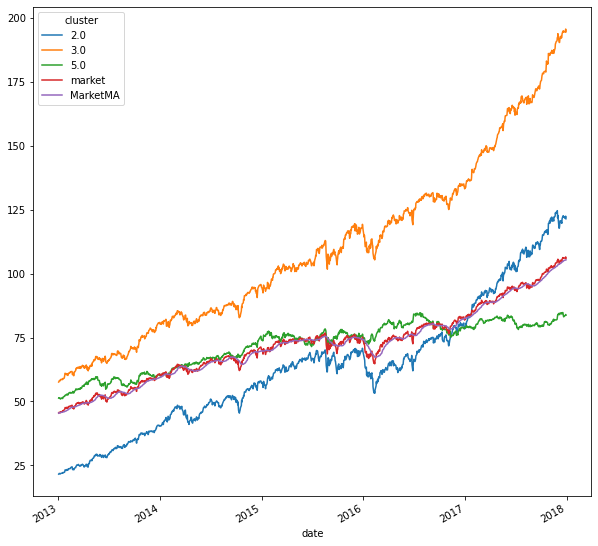

In [220]:
df_Cluster.plot(figsize=(10,10)) #the same plot without the irrelevant clusters. 

This figure shows the same as the previous one without irrelevant clusters. I decided to create the following strategy. If market moving average goes down, I will invest in cluster 5 in order to stabilize during drawdowns. On the otherside, I will invest in cluster 2 and 3 if market moving average goes up to fully benefit from drawups. I decide to pick market moving average growth as my main criteria, because it evolves smoother than the daily market returns. For this reason my strategy will be less prone to respond to irrelevant daily fluctuations. 

In [221]:
df_Cluster['marketReturn']= df_Cluster['market'].pct_change(1) # This feature is nescessary later on to compare the strategy returns with the market returns.
df_Cluster['ChangeMarketMA'] = df_Cluster['MarketMA'].pct_change(1) # Creating a feature that indicates the growth of the monthly market moving average 
df_Cluster.head() 

cluster,2.0,3.0,5.0,market,MarketMA,marketReturn,ChangeMarketMA
date,,,,,,,
2013-01-02,21.581872,57.603788,51.319083,45.436453,45.436453,NaN,NaN
2013-01-03,21.696945,57.736442,51.271079,45.489154,45.462804,0.001160,0.000580
2013-01-04,21.877974,58.109983,51.471453,45.806799,45.577469,0.006983,0.002522
2013-01-07,21.753207,58.283592,51.195687,45.731660,45.616016,-0.001640,0.000846
2013-01-08,21.670585,58.144701,50.972293,45.601128,45.613039,-0.002854,-0.000065


In [222]:
df_Cluster['Criteria1'] = df_Cluster['ChangeMarketMA'] > 0 
df_Cluster['BuyKeepStocksCluster5'] = np.where(df_Cluster['Criteria1']==False, 1, 0)
df_Cluster['BuyKeepStocksCluster5'] = df_Cluster['BuyKeepStocksCluster5'].shift(1) 
df_Cluster['BuyKeepStocksCluster2&3'] = np.where(df_Cluster['Criteria1']==True, 1, 0) 
df_Cluster['BuyKeepStocksCluster2&3'] = df_Cluster['BuyKeepStocksCluster2&3'].shift(1)
df_Cluster.head() #creating my strategy, if market moving average declines I invest all in cluster 5, if it grows I invest all of my investment in cluster 2 and 3 evenly.
# I set shift(1), because I can only respond to a market change one day later. 

cluster,2.0,3.0,5.0,market,MarketMA,marketReturn,ChangeMarketMA,Criteria1,BuyKeepStocksCluster5,BuyKeepStocksCluster2&3
date,,,,,,,,,,
2013-01-02,21.581872,57.603788,51.319083,45.436453,45.436453,NaN,NaN,False,NaN,NaN
2013-01-03,21.696945,57.736442,51.271079,45.489154,45.462804,0.001160,0.000580,True,1.0,0.0
2013-01-04,21.877974,58.109983,51.471453,45.806799,45.577469,0.006983,0.002522,True,0.0,1.0
2013-01-07,21.753207,58.283592,51.195687,45.731660,45.616016,-0.001640,0.000846,True,0.0,1.0
2013-01-08,21.670585,58.144701,50.972293,45.601128,45.613039,-0.002854,-0.000065,False,0.0,1.0


In [223]:
df_Cluster['ReturnsCluster5'] = df_Cluster[5.0].pct_change(1)
df_Cluster['ReturnsCluster2'] = df_Cluster[2.0].pct_change(1)
df_Cluster['ReturnsCluster3'] = df_Cluster[3.0].pct_change(1)
df_Cluster['ReturnsCluster2&3'] = (df_Cluster['ReturnsCluster2']+df_Cluster['ReturnsCluster3'])/2
df_Cluster['StrategyReturns']= (df_Cluster['ReturnsCluster2&3']*df_Cluster['BuyKeepStocksCluster2&3'])+(df_Cluster['ReturnsCluster5']*df_Cluster['BuyKeepStocksCluster5'])
#computing the returns of my strategy if I ran it between 2013-2017 

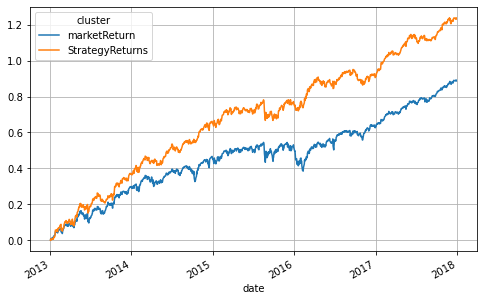

In [224]:
df_Cluster[['marketReturn','StrategyReturns']].cumsum().plot(grid=True,figsize=(8,5)) #plotting my strategy returns and those of the market.

It shows that my strategy would have performed really well in the period between 2013 and 2017. However, my results are strongly biased and these results are obvious, because I first calculated which stocks performed well during this period and then decided to invest in these stocks during this same period. In the real world you do not have the ability to go back in time! For that reason I will test the results of my strategy between 2018-2019. 

In [225]:
Ssd=df_Cluster['StrategyReturns'].std(axis = 0, skipna = True)
Sr=df_Cluster['StrategyReturns'].mean(axis = 0, skipna = True)
Sr/Ssd #the Sharpe ratio of my trading strategy, not taking into account the risk free interest rate as I only compare it to the market's Sharpe.

0.11831873374753368

In [226]:
Msd = df_Cluster['marketReturn'].std(axis = 0, skipna = True)
Mr=df_Cluster['marketReturn'].mean(axis = 0, skipna = True)
Mr/Msd 
# Sharpe ratio of the market portfolio in the same period (without risk free interest rate). My strategy outperformed the market, because Sharpe is higher. 

0.08830950079768622

### Backtesting 

In this part I will test my trading strategy over the period 2018 till the end of 2019 and compare it to the market portfolio in that same period. 

In [227]:
dfTest.reset_index(level=0, inplace=True)
dfTest = dfTest.melt('date', var_name='Name', value_name='Prices')
dfTest.set_index(['Name'], inplace=True)
dfTest['cluster'] = cluster['cluster']
dfTest.head() #Using the dataframe of stock adjusted close prices from 2018-2019 and adding the clusters to the dataframe. 

,date,Prices,cluster
Name,,,
MMM,2018-01-02,214.096344,3.0
MMM,2018-01-03,214.087234,3.0
MMM,2018-01-04,216.885666,3.0
MMM,2018-01-05,218.575592,3.0
MMM,2018-01-08,217.866882,3.0


In [228]:
a = dfTest.groupby(['date','cluster']).mean()
dfClusterTest = a['Prices']
dfClusterTest = pd.DataFrame(dfClusterTest)
dfClusterTest.reset_index(level=0, inplace=True)
dfClusterTest.reset_index(level=0, inplace=True)
dfClusterTest = dfClusterTest.pivot(index='date', columns='cluster', values='Prices')
dfClusterTest.head() #creating a dataframe that shows the average stock price of clusters per day.

cluster,0.0,1.0,2.0,3.0,4.0,5.0
date,,,,,,
2018-01-02,47.034095,86.629932,124.345724,195.989424,104.703401,83.731546
2018-01-03,47.346605,87.164756,126.018565,198.022802,105.855426,84.059858
2018-01-04,47.845153,87.223896,126.377949,198.476974,106.119237,83.917517
2018-01-05,47.997169,87.837655,127.726734,200.702421,106.772711,84.285649
2018-01-08,48.146231,88.223528,128.783373,201.976236,107.146359,84.532548


In [229]:
dfClusterTest['market'] = dfClusterTest.mean(axis=1)
dfClusterTest['MarketMA'] = dfClusterTest['market'].rolling(window=20, min_periods=1).mean()
dfClusterTest.head() #again adding the market price per day and the monthly moving average market price. 

cluster,0.0,1.0,2.0,3.0,4.0,5.0,market,MarketMA
date,,,,,,,,
2018-01-02,47.034095,86.629932,124.345724,195.989424,104.703401,83.731546,107.072354,107.072354
2018-01-03,47.346605,87.164756,126.018565,198.022802,105.855426,84.059858,108.078002,107.575178
2018-01-04,47.845153,87.223896,126.377949,198.476974,106.119237,83.917517,108.326788,107.825714
2018-01-05,47.997169,87.837655,127.726734,200.702421,106.772711,84.285649,109.220390,108.174383
2018-01-08,48.146231,88.223528,128.783373,201.976236,107.146359,84.532548,109.801379,108.499783


In [231]:
del dfClusterTest[0]
del dfClusterTest[4]
del dfClusterTest[1] #removing cluster 0, 4 and 1 as these are not part of our strategy. 

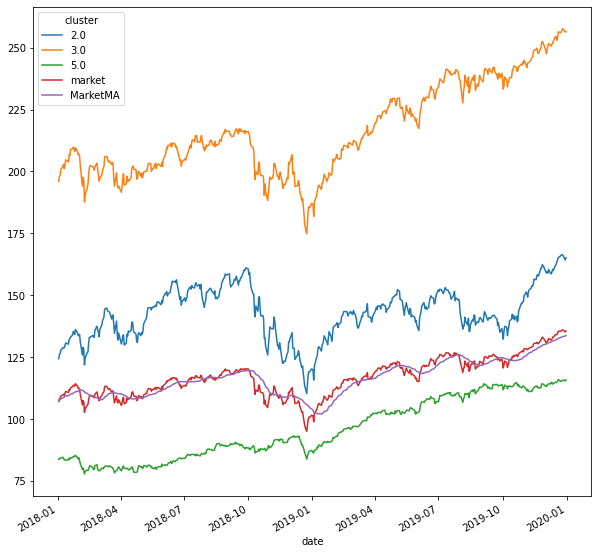

In [232]:
dfClusterTest.plot(figsize=(10,10)) #Creating a plot for stock cluster prices that are in my strategy and the market price. 

The plot shows that especially cluster 3 did have high returns. The returns of cluster 2 are significantly lower than those of cluster 3, but still slightly higher than the market average. However, the plot shows that both cluster 2 and 3 had an extreme drop in price at the end of 2018. The market price also dropped during this period. Cluster 5 also dropped but with less extreme numbers than cluster 2 and 3. Thus, it seems that the clusters are behaving somewhat similarly as during the previous 5 years. Hopefully this is also reflected in our strategy returns! 

In [243]:
dfClusterTest['marketReturn'] =  dfClusterTest['market'].pct_change(1) #This feature is nescessary later on to compare the strategy returns with the market returns.
dfClusterTest['ChangeinMa'] = dfClusterTest['MarketMA'].pct_change(1) #creating a feauture that indicates the growth of the monthly market moving average

In [244]:
dfClusterTest['Criteria1'] = dfClusterTest['ChangeinMa'] > 0 
dfClusterTest['BuyKeepStocksCluster5'] = np.where(dfClusterTest['Criteria1']==False, 1, 0)
dfClusterTest['BuyKeepStocksCluster5'] = dfClusterTest['BuyKeepStocksCluster5'].shift(1)
dfClusterTest['BuyKeepStocksCluster2&3'] = np.where(dfClusterTest['Criteria1']==True, 1, 0)
dfClusterTest['BuyKeepStocksCluster2&3'] = dfClusterTest['BuyKeepStocksCluster2&3'].shift(1)
dfClusterTest.head() #creating my strategy, if market moving average declines I invest all in cluster 5, if it grows I invest all my investment in cluster 2 and 3 evenly.
# I set shift(1), because I can only respond to a market change one day later. 

cluster,2.0,3.0,5.0,market,MarketMA,marketReturn,ChangeinMa,Criteria1,BuyKeepStocksCluster5,BuyKeepStocksCluster2&3,ReturnsCluster5,ReturnsCluster2,ReturnsCluster3,ReturnsCluster2&3,StrategyReturns
date,,,,,,,,,,,,,,,
2018-01-02,124.345724,195.989424,83.731546,107.072354,107.072354,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,126.018565,198.022802,84.059858,108.078002,107.575178,0.009392,0.004696,True,1.0,0.0,0.003921,0.013453,0.010375,0.011914,0.003921
2018-01-04,126.377949,198.476974,83.917517,108.326788,107.825714,0.002302,0.002329,True,0.0,1.0,-0.001693,0.002852,0.002294,0.002573,0.002573
2018-01-05,127.726734,200.702421,84.285649,109.220390,108.174383,0.008249,0.003234,True,0.0,1.0,0.004387,0.010673,0.011213,0.010943,0.010943
2018-01-08,128.783373,201.976236,84.532548,109.801379,108.499783,0.005319,0.003008,True,0.0,1.0,0.002929,0.008273,0.006347,0.007310,0.007310


In [245]:
dfClusterTest['ReturnsCluster5'] = dfClusterTest[5.0].pct_change(1)
dfClusterTest['ReturnsCluster2'] = dfClusterTest[2.0].pct_change(1)
dfClusterTest['ReturnsCluster3'] = dfClusterTest[3.0].pct_change(1)
dfClusterTest['ReturnsCluster2&3'] = (dfClusterTest['ReturnsCluster2']+dfClusterTest['ReturnsCluster3'])/2
dfClusterTest['StrategyReturns']= (dfClusterTest['ReturnsCluster2&3']*dfClusterTest['BuyKeepStocksCluster2&3'])+(dfClusterTest['ReturnsCluster5']*dfClusterTest['BuyKeepStocksCluster5'])
#computing the returns of my strategy if I ran it between 2018-2019

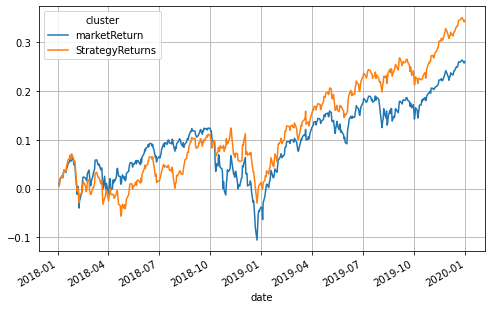

In [246]:
dfClusterTest[['marketReturn','StrategyReturns']].cumsum().plot(grid=True,figsize=(8,5)) #plotting the cumulative returns of my strategy and market portfolio

This plot shows that my strategy did again have higher total returns as the market portfolio. However, it was more unstable (riskier) and clearly more prone to market drawdowns than it was in the period between 2013-2017. 

In [248]:
Ssd=dfClusterTest['StrategyReturns'].std(axis = 0, skipna = True)
Sr=dfClusterTest['StrategyReturns'].mean(axis = 0, skipna = True)
Sr/Ssd #this is the Sharpe ratio of my strategy between 2018-2019 without taking account of risk-free interest

0.07455936923035289

In [249]:
Msd = dfClusterTest['marketReturn'].std(axis = 0, skipna = True)
Mr= dfClusterTest['marketReturn'].mean(axis = 0, skipna = True)
Mr/Msd #this is the Sharpe ratio of the market portfolio between 2018-2019 without taking account of risk-free interest

0.05251545893269303

To conclude, my trading strategy had again a higher Sharpe ratio than the market portfolio, which means that I outperformed the market. I am relatively happy with the result considering that this was my first trading strategy and I did not make things too complicated. In contrast, I need to acknowledge that this strategy has many downsides. At some points in time my trading strategy had less total returns than the market portfolio, also the total returns have sometimes been negative and the volatility was way too high for any serious investor to adopt this strategy. 